# Unsupervised surgery pipeline with TRVAE

In [ ]:
import os
os.chdir('../')
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=UserWarning)

In [1]:
import scanpy as sc
import torch
import scarches as sca
import numpy as np
import gdown
from scipy.sparse import issparse

/Users/chelseaalexandra.bright/miniconda3/envs/ivelo/lib/python3.9/site-packages/scvi/_settings.py:63: UserWarning: Since v1.0.0, scvi-tools no longer uses a random seed by default. Run `scvi.settings.seed = 0` to reproduce results from previous versions.
  self.seed = seed
/Users/chelseaalexandra.bright/miniconda3/envs/ivelo/lib/python3.9/site-packages/scvi/_settings.py:70: UserWarning: Setting `dl_pin_memory_gpu_training` is deprecated in v1.0 and will be removed in v1.1. Please pass in `pin_memory` to the data loaders instead.
  self.dl_pin_memory_gpu_training = (
/Users/chelseaalexandra.bright/miniconda3/envs/ivelo/lib/python3.9/site-packages/flax/struct.py:132: FutureWarning: jax.tree_util.register_keypaths is deprecated, and will be removed in a future release. Please use `register_pytree_with_keys()` instead.
  jax.tree_util.register_keypaths(data_clz, keypaths)
/Users/chelseaalexandra.bright/miniconda3/envs/ivelo/lib/python3.9/site-packages/flax/struct.py:132: FutureWarning: ja

In [2]:
sc.settings.set_figure_params(dpi=200, frameon=False)
sc.set_figure_params(dpi=200)
sc.set_figure_params(figsize=(4, 4))
torch.set_printoptions(precision=3, sci_mode=False, edgeitems=7)

### Set relevant anndata.obs labels and training length

Here we use the CelSeq2 and SS2 studies as query data and the other 3 studies as reference atlas. We strongly suggest to use earlystopping to avoid over-fitting. The best earlystopping criteria is the 'val_unweighted_loss' for TRVAE.

In [16]:
condition_key = 'condition'
cell_type_key = 'cell_label'

trvae_epochs = 500

early_stopping_kwargs = {
    "early_stopping_metric": "val_unweighted_loss",
    "threshold": 0,
    "patience": 20,
    "reduce_lr": True,
    "lr_patience": 13,
    "lr_factor": 0.1,
}

### Download Dataset and split into reference dataset and query dataset

In [119]:
url = "https://drive.google.com/uc?id=1v3-ZmktCS61-oe2v1VtHtIhCeQl78SCN"
output = 'haber_count.h5ad'
gdown.download(url, output, quiet=False)

Downloading...
From: https://drive.google.com/uc?id=1v3-ZmktCS61-oe2v1VtHtIhCeQl78SCN
To: /Users/chelseaalexandra.bright/Downloads/haber_count.h5ad
100%|██████████| 34.6M/34.6M [00:01<00:00, 31.1MB/s]


'haber_count.h5ad'

In [8]:
adata = sc.read('haber_count.h5ad')

/Users/chelseaalexandra.bright/miniconda3/envs/ivelo/lib/python3.9/site-packages/anndata/__init__.py:51: FutureWarning: `anndata.read` is deprecated, use `anndata.read_h5ad` instead. `ad.read` will be removed in mid 2024.
  warnings.warn(


This line makes sure that count data is in the adata.X. Remember that count data in adata.X is necessary when using "nb" or "zinb" loss. However, when using trVAE with MSE loss normalized data is necessary in adata.X

In [13]:
sc.pp.normalize_total(adata)
sc.pp.log1p(adata)
sc.pp.highly_variable_genes(
    adata,
    n_top_genes=2000,
    batch_key="condition",
    subset=True)

/Users/chelseaalexandra.bright/miniconda3/envs/ivelo/lib/python3.9/site-packages/scanpy/preprocessing/_highly_variable_genes.py:220: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  disp_grouped = df.groupby('mean_bin')['dispersions']
/Users/chelseaalexandra.bright/miniconda3/envs/ivelo/lib/python3.9/site-packages/scanpy/preprocessing/_highly_variable_genes.py:220: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  disp_grouped = df.groupby('mean_bin')['dispersions']
/Users/chelseaalexandra.bright/miniconda3/envs/ivelo/lib/python3.9/site-packages/scanpy/preprocessing/_highly_variable_genes.py:220: FutureWarning: The 

In [14]:
sc.pp.neighbors(adata)
sc.tl.umap(adata)

         Falling back to preprocessing with `sc.pp.pca` and default params.


/Users/chelseaalexandra.bright/miniconda3/envs/ivelo/lib/python3.9/site-packages/anndata/_core/anndata.py:522: FutureWarning: The dtype argument is deprecated and will be removed in late 2024.
  warnings.warn(


/Users/chelseaalexandra.bright/miniconda3/envs/ivelo/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:1251: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/Users/chelseaalexandra.bright/miniconda3/envs/ivelo/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/Users/chelseaalexandra.bright/miniconda3/envs/ivelo/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:1251: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing 

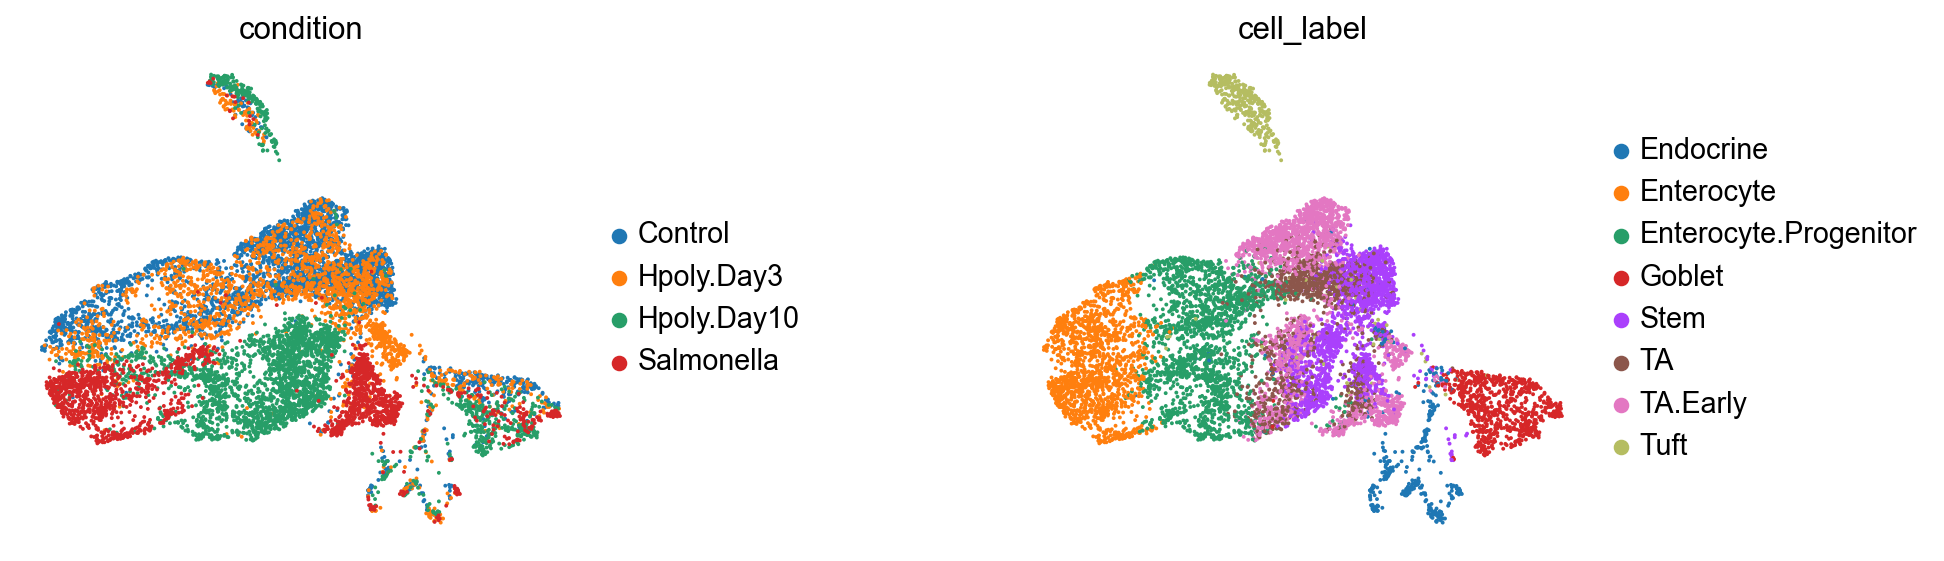

In [17]:
sc.pl.umap(adata, color=[condition_key, cell_type_key], 
           wspace=0.6, 
           frameon=False)

### Create TRVAE model and train it on reference dataset

Create the trVAE model instance with NB loss as default. Insert "recon_loss='mse'," or "recon_loss='zinb'," to change the reconstruction loss.

In [18]:
conditions = adata.obs[condition_key].unique().tolist()

In [19]:
trvae = sca.models.TRVAE(
    adata=adata,
    condition_key=condition_key,
    conditions=conditions,
    hidden_layer_sizes=[128, 128],
)


INITIALIZING NEW NETWORK..............
Encoder Architecture:
	Input Layer in, out and cond: 2000 128 4
	Hidden Layer 1 in/out: 128 128
	Mean/Var Layer in/out: 128 10
Decoder Architecture:
	First Layer in, out and cond:  10 128 4
	Hidden Layer 1 in/out: 128 128
	Output Layer in/out:  128 2000 



In [20]:
trvae.train(
    n_epochs=trvae_epochs,
    alpha_epoch_anneal=200,
    early_stopping_kwargs=early_stopping_kwargs
)

Preparing (9842, 2000)
Instantiating dataset
 |████----------------| 21.6%  - val_loss: 367.1541175842 - val_recon_loss: 357.8970184326 - val_kl_loss: 7.9313664436 - val_mmd_loss: 5.01382470134
ADJUSTED LR
 |██████--------------| 33.8%  - val_loss: 368.4749832153 - val_recon_loss: 357.8421020508 - val_kl_loss: 6.4321784377 - val_mmd_loss: 5.2298486233
ADJUSTED LR
 |███████-------------| 38.0%  - val_loss: 368.7791366577 - val_recon_loss: 357.8821601868 - val_kl_loss: 6.1740977764 - val_mmd_loss: 5.0624444485
ADJUSTED LR
 |███████-------------| 39.4%  - val_loss: 368.6208496094 - val_recon_loss: 357.5362205505 - val_kl_loss: 6.1319574118 - val_mmd_loss: 5.0753057003
Stopping early: no improvement of more than 0 nats in 20 epochs
If the early stopping criterion is too strong, please instantiate it with different parameters in the train method.
Saving best state of network...
Best State was in Epoch 196


### Create anndata file of latent representation and compute UMAP

In [26]:
adata_latent = sc.AnnData(trvae.get_latent())
adata_latent.obs['cell_label'] = adata.obs[cell_type_key].tolist()
adata_latent.obs['condition'] = adata.obs[condition_key].tolist()

In [41]:
adata_latent.obs

,cell_label,condition,leiden
0,Enterocyte.Progenitor,Control,2
1,Stem,Control,0
2,Stem,Control,0
3,Stem,Control,9
4,Enterocyte.Progenitor,Control,2
...,...,...,...
9837,TA,Salmonella,0
9838,Enterocyte,Salmonella,5
9839,Stem,Salmonella,0
9840,Endocrine,Salmonella,16


/Users/chelseaalexandra.bright/miniconda3/envs/ivelo/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:1251: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/Users/chelseaalexandra.bright/miniconda3/envs/ivelo/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/Users/chelseaalexandra.bright/miniconda3/envs/ivelo/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:1251: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing 

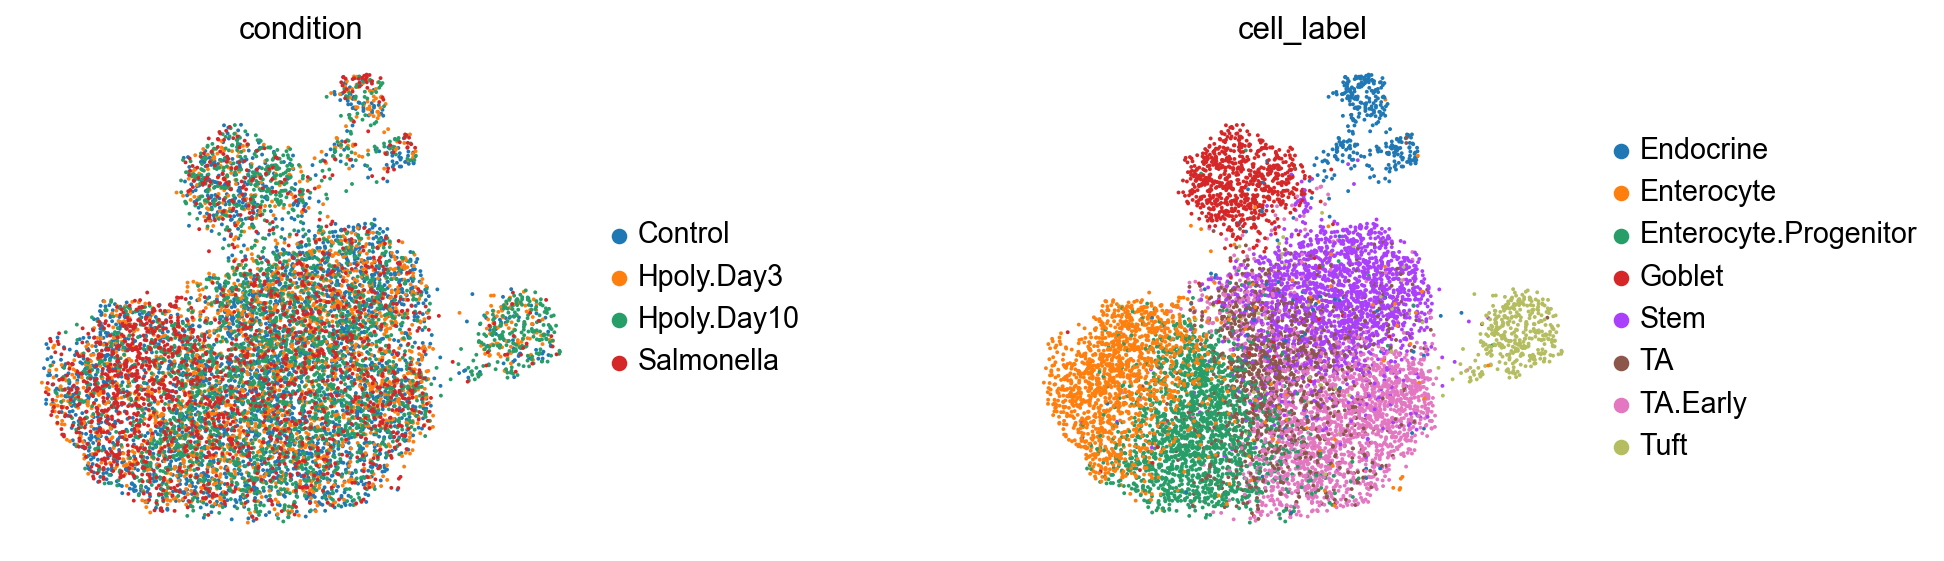

In [28]:
sc.pp.neighbors(adata_latent, n_neighbors=8)
sc.tl.leiden(adata_latent)
sc.tl.umap(adata_latent)
sc.pl.umap(adata_latent,
           color=['condition', 'cell_label'],
           frameon=False,
           wspace=0.6,
           )

### Get corrected gene expression data

we transfer all conditions to the batch labels with maximum number of samples. 
`target_condition` is the the condtion that you want your  source `adata` be transformed to.

In [27]:
adata_latent.obs[condition_key].value_counts()

condition
Control        3240
Hpoly.Day10    2711
Hpoly.Day3     2121
Salmonella     1770
Name: count, dtype: int64

In [87]:
target_condition = adata_latent.obs[condition_key].value_counts().index[0]

In [113]:
def get_reconstruction(model, x, encoder_labels=None, decoder_labels = None):

    x_ = torch.log(1 + x)
    if model.model.recon_loss == 'mse':
        x_ = x
    
    z_mean, z_log_var = model.model.encoder(x_, encoder_labels)
    latent = model.model.sampling(z_mean, z_log_var)
    output = model.model.decoder(latent, decoder_labels)
    return output[0]

In [108]:
def perturbation_prediction(
    model,
    x=None,
    c=None,
    target_condition=None
    ):    

    device = next(model.model.parameters()).device
    if x is None and c is None:
        x = model.adata.X
        if model.conditions_ is not None:
            c = model.adata.obs[model.condition_key_]

    if c is not None:
        c = np.asarray(c)
        if not set(c).issubset(model.conditions_):
            raise ValueError("Incorrect conditions")
        labels = np.zeros(c.shape[0])
        for condition, label in model.model.condition_encoder.items():
            labels[c == condition] = label
        c = torch.tensor(labels, device=device)

    from scarches.dataset.trvae._utils import label_encoder
    encoder_labels = label_encoder(adata, model.model.condition_encoder, condition_key)
    if target_condition is not None:
        decoder_labels = np.zeros_like(encoder_labels) + model.model.condition_encoder[
            target_condition]
    else:
        decoder_labels = label_encoder(adata, model.model.condition_encoder, condition_key)

    latents = []
    indices = torch.arange(x.shape[0])
    subsampled_indices = indices.split(512)
    for batch in subsampled_indices:
        x_batch = x[batch, :]
        if issparse(x_batch):
            x_batch = x_batch.toarray()
        x_batch = torch.tensor(x_batch, device=device)
        encoder_labels = torch.tensor(encoder_labels, device=device)
        decoder_labels = torch.tensor(decoder_labels, device=device)
        latent = get_reconstruction(model, x_batch, encoder_labels[batch], decoder_labels[batch])
        latents += [latent.cpu().detach()]

    return np.array(torch.cat(latents))

In [114]:
corrected_data = perturbation_prediction(trvae, target_condition=target_condition)

/var/folders/m3/b3nxvvbs60g6xqr98n8yr3100000gn/T/ipykernel_37573/91779306.py:43: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  encoder_labels = torch.tensor(encoder_labels, device=device)
/var/folders/m3/b3nxvvbs60g6xqr98n8yr3100000gn/T/ipykernel_37573/91779306.py:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  decoder_labels = torch.tensor(decoder_labels, device=device)


In [116]:
corrected_adata = sc.AnnData(corrected_data)
corrected_adata.obs['cell_label'] = adata.obs[cell_type_key].tolist()
corrected_adata.obs['condition'] = adata.obs[condition_key].tolist()

#### UMAP visualization of corrected gene expression 

In [117]:
sc.pp.neighbors(corrected_adata)
sc.tl.umap(corrected_adata)

         Falling back to preprocessing with `sc.pp.pca` and default params.


/Users/chelseaalexandra.bright/miniconda3/envs/ivelo/lib/python3.9/site-packages/anndata/_core/anndata.py:522: FutureWarning: The dtype argument is deprecated and will be removed in late 2024.
  warnings.warn(


As observed  in the corrected gene expression data all samples were mapped to control cells and are mixd now

/Users/chelseaalexandra.bright/miniconda3/envs/ivelo/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:1251: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/Users/chelseaalexandra.bright/miniconda3/envs/ivelo/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/Users/chelseaalexandra.bright/miniconda3/envs/ivelo/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:1251: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing 

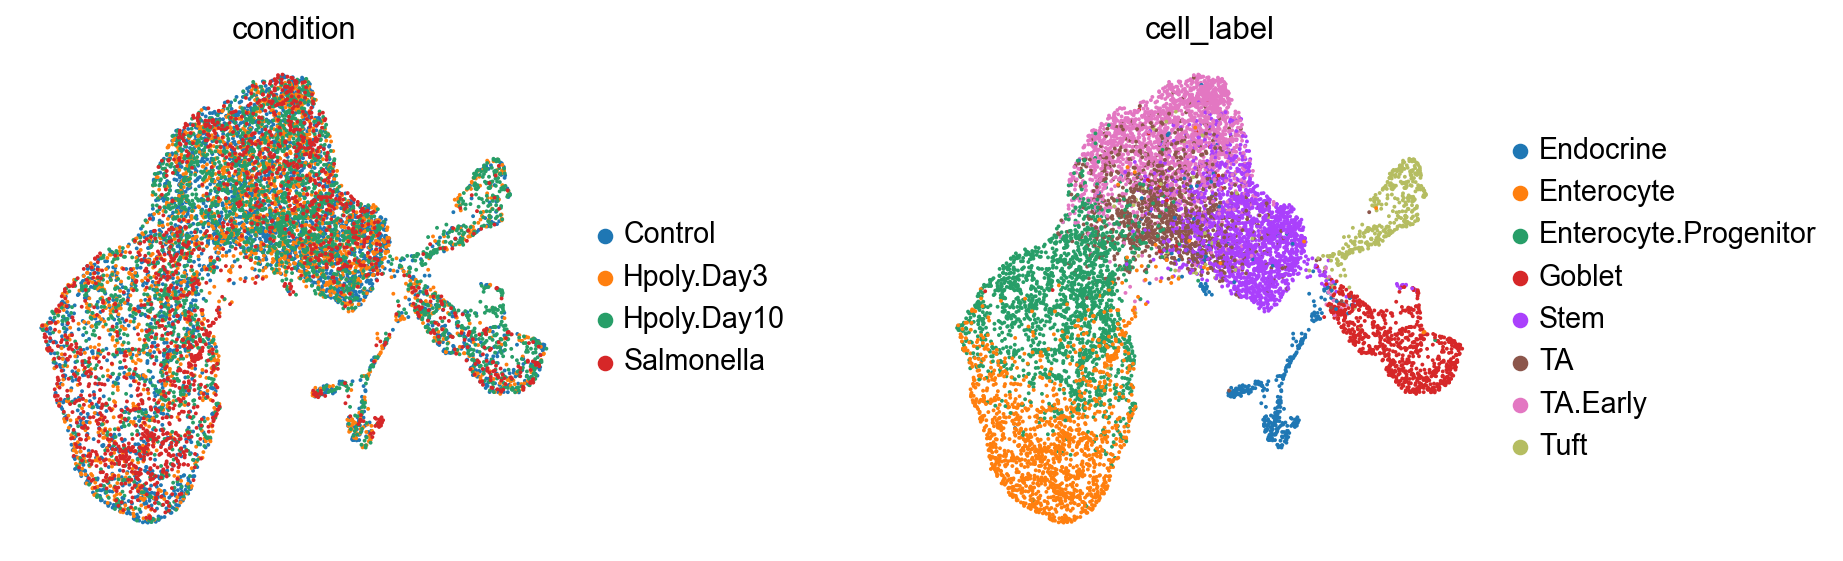

In [118]:
sc.pl.umap(corrected_adata, color=[condition_key, cell_type_key], wspace=0.5, frameon=False)